In [49]:

import pandas as pd
import matplotlib.pyplot as plt
import requests, time
import numpy as np
from datetime import date, timedelta, datetime

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

latest_date=(date.today() - timedelta(days=1)).strftime("%Y-%m-%d")
nations={"England":"https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&areaCode=E92000001&metric=newAdmissions&metric=newCasesBySpecimenDate&metric=newDeaths28DaysByDeathDate&format=csv",
        "N. Ireland":"https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&areaCode=N92000002&metric=newAdmissions&metric=newCasesBySpecimenDate&metric=newDeaths28DaysByDeathDate&format=csv",
        "Scotland":"https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&areaCode=S92000003&metric=newAdmissions&metric=newCasesBySpecimenDate&metric=newDeaths28DaysByDeathDate&format=csv",
        "Wales":"https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&areaCode=W92000004&metric=newAdmissions&metric=newCasesBySpecimenDate&metric=newDeaths28DaysByDeathDate&format=csv"}
population={"England":56286961,
             "N. Ireland":1893700,
             "Scotland":5463300,
             "Wales":3152879}
threshold={"hospital":6,
           "deaths":6,
           "cases":6}#Usually 3 is fine but apparently we don't need data at this vital time
average_period=7
load_new=False

Area Codes:
    England - E92000001
    N. Ireland - E92000002
    Scotland - E92000003
    Wales - E92000004

In [50]:
data={k:[] for k in nations.keys()}
for name,url in nations.items():
    if load_new==True:
        f = requests.get(url)
        with open("%s.csv"%(name),"w+") as out:
            out.seek(0)
            out.write(f.text)
            out.truncate()
    data[name]=pd.read_csv("%s.csv"%name)
    data[name]=data[name].drop(["areaType","areaCode","areaName"],axis=1)
    data[name]=data[name].rename(columns={'newAdmissions':'hospital',"newCasesBySpecimenDate":"cases","newDeaths28DaysByDeathDate":"deaths"})
    data[name].date=pd.to_datetime(data[name].date)
    for metric in ["hospital","cases","deaths"]:
        data[name][metric]=data[name][metric][threshold[metric]:]
        data[name][metric]=data[name][metric].rolling(window=average_period, min_periods=1).mean()
    data[name]=data[name].apply(lambda x: x/(population[name]/100000) if x.name in ["cases","deaths","hospital"] else x,  axis = 0)
    #data[name]=data[name].iloc[threshold:]

In [54]:
def plot(nations=["England","Wales"],metrics=["deaths","cases","hospital"],start_date=None):
    plt.rcParams["figure.figsize"] = (15,10)
    fig,ax=plt.subplots()
    ax2=ax.twinx()
    for metric in metrics:
        for nation in nations:
            if metric=="cases":
                ax.plot(data[nation]["date"],data[nation][metric],label="%s - %s"%(nation,metric))
            else:
                ax2.plot(data[nation]["date"],data[nation][metric],label="%s - %s"%(nation,metric),linestyle="--")
    ax.legend()
    #ax2.legend()
    ax.set_ylabel("Per 100k")
    ax2.set_ylabel("Deaths per 100k")
    if start_date!=None:
        plt.xlim(xmin=start_date)

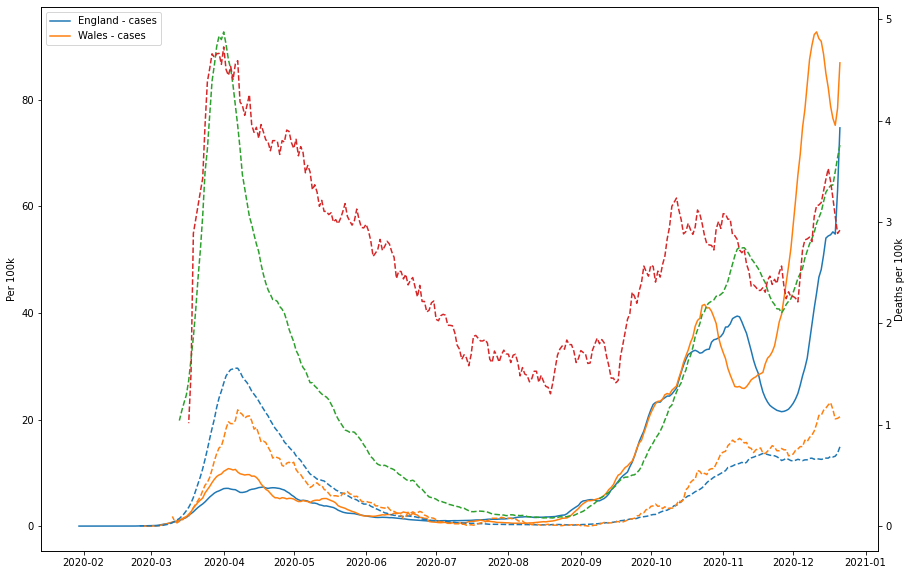

In [55]:
plot()

In [53]:
data["England"].iloc[3:]

,date,hospital,cases,deaths
3,2020-12-24,NaN,NaN,NaN
4,2020-12-23,NaN,NaN,NaN
5,2020-12-22,NaN,NaN,NaN
6,2020-12-21,3.757531,74.738446,0.781709
7,2020-12-20,3.634057,62.965737,0.718639
...,...,...,...,...
328,2020-02-03,NaN,0.001523,NaN
329,2020-02-02,NaN,0.001269,NaN
330,2020-02-01,NaN,0.000254,NaN
331,2020-01-31,NaN,0.000254,NaN


In [31]:
42.674182*population["England"]/100000

24020.000179409024